# Sieci neuronowe

## Introduction

This notebooks explores core concepts both theoretically and through practical implementation.

The goal of this project is to become familiar with the concepts of neural networks and deep learning. During the project we will work with the following topics:

- training simple neural networks, in particular:

  - linear regression implemented with neural networks

  - optimization of a cost (loss) function

  - the gradient descent algorithm

  - the Multilayer Perceptron (MLP) network

- architecture and hyperparameters of MLP networks, in particular:

  - dense (fully connected) layers

  - activation functions

  - regularization techniques: L2, dropout

## Introduction

Before starting with neural networks, let us look at a simple example of linear regression on synthetic data.

In [ ]:
from typing import Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

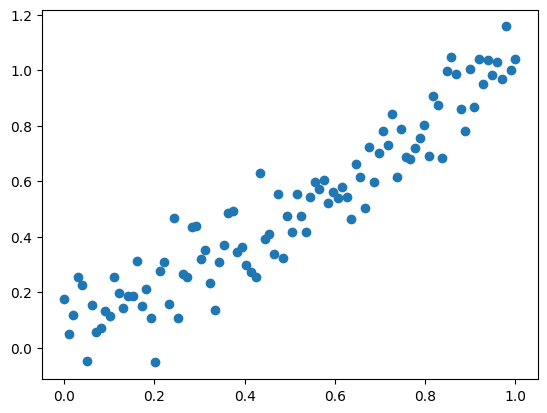

In [ ]:
np.random.seed(0)

x = np.linspace(0, 1, 100)
y = x + np.random.normal(scale=0.1, size=x.shape)

plt.scatter(x, y)

In the case of simple linear regression (one variable), the model has the form $\hat{y} = \alpha x + \beta$ , with two parameters that will be learned.

The measure of the model's mismatch for given parameters is the **cost function**, also called the objective function. The most commonly used one is the **mean squared error (MSE)**:

$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y - \hat{y})^2
$$

Which values of $\alpha$ i $\beta$ should we start from? In the simplest case, it is enough to initialize them as small random floating-point numbers


In [ ]:
def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
    return np.mean((y - y_hat) ** 2)

MSE: 0.133


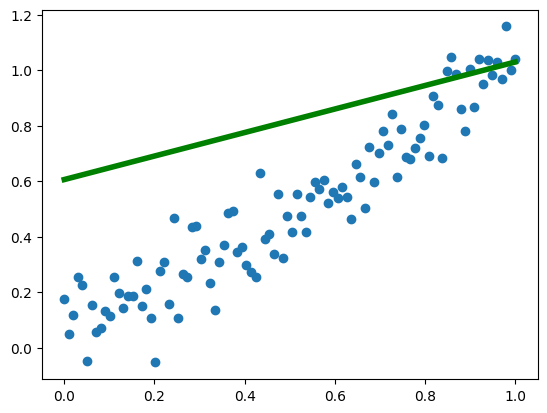

In [ ]:
a = np.random.rand()
b = np.random.rand()
print(f"MSE: {mse(y, a * x + b):.3f}")

plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Random parameters don’t perform very well. How can we fit our line to the data better? We can always try to derive an analytical solution, and in this case we can even succeed. However, this is a special and rather rare situation, and in particular it won’t be feasible in larger neural networks.

The derivative is exactly equal to the limit of a function. For a small $\epsilon$ it can be approximated as:
$$\large
\frac{f(x)}{dx} \approx \frac{f(x+\epsilon) - f(x)}{\epsilon}
$$

Looking at this equation, we see that:
* for an increasing function ($f(x+\epsilon) > f(x)$) the expression $\frac{f(x)}{dx}$ will be positive
* for a decreasing function ($f(x+\epsilon) < f(x)$) the expression $\frac{f(x)}{dx}$ will be negative

So we can determine the direction in which the function decreases by looking at the sign of the derivative. It has also been observed that the magnitude of $\frac{f(x)}{dx}$ is larger the farther we are from a minimum (or maximum). The derivative therefore indicates the direction in which the function grows fastest, and the opposite direction is where it decreases fastest.

Applying this to optimization, we have:
$$\large
x_{t+1} = x_{t} -  \alpha * \frac{f(x)}{dx}
$$

$\alpha$ is a small value (typically on the order of $10^{-5}$–$10^{-2}$), introduced to maintain the assumption of a small parameter change ($\epsilon$). It’s called the **learning rate** and is usually the most important hyperparameter when training a network.

This method assumes we use the entire dataset to update the parameters at every step, which is simply called GD (from *gradient descent*) or *full batch GD*. In that case every optimization step is called an **epoch**.

The larger the learning rate, the bigger the steps we take during minimization. This lets us train faster, but there’s a risk of “overshooting” minima. A smaller learning rate means slower but more precise training. However, it doesn’t always lead to better results, because we may get stuck in a local minimum. The learning rate can also be changed during training, which is called **learning rate scheduling (LR scheduling)**. Visually:

![learning_rate](http://www.bdhammel.com/assets/learning-rate/lr-types.png)


![interactive LR](http://cdn-images-1.medium.com/max/640/1*eeIvlwkMNG1wSmj3FR6M2g.gif)

Let’s compute the derivative for our MSE cost function. We take the derivative with respect to the model parameters, because these are what we want to adjust so that the cost becomes as small as possible:

$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y_i - \hat{y_i})^2
$$

In the expression above only $y_i$ depends on $a$ and $b$. We can apply the chain rule and compute the derivatives with respect to our parameters as follows:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} a}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} b}
$$

Let’s compute these derivatives step by step:

$$\large
\frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} = -2 \cdot (y_i - \hat{y_i})
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} a} = x_i
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} b} = 1
$$

Combining the results, we get:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i}) \cdot {x_i}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i})
$$

Updating the parameters looks like this:

$$\large
a' = a - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \cdot x_i \right)
$$
$$\large
b' = b - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \right)
$$

We compute the derivative of the cost function and then, using the chain rule, “trace back” how each parameter affects the error and how it should be updated. This is called **backpropagation**, and it’s the core mechanism that makes it possible to train neural networks using gradient descent.


In [ ]:
def optimize(
    x: np.ndarray, y: np.ndarray, a: float, b: float, learning_rate: float = 0.1
):
    y_hat = a * x + b
    errors = y - y_hat
    N = len(y)
    a = a - learning_rate * (((-2)/N) *  np.sum(errors * x))
    b = b - learning_rate * (((-2)/N) * np.sum(errors))

    return a,b

In [ ]:
for i in range(1000):
    loss = mse(y, a * x + b)
    a, b = optimize(x, y, a, b)
    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  0.1330225119404028
step 100 loss:  0.012673197778527677
step 200 loss:  0.010257153540857817
step 300 loss:  0.0100948037549359
step 400 loss:  0.010083894412889118
step 500 loss:  0.010083161342973332
step 600 loss:  0.010083112083219709
step 700 loss:  0.010083108773135261
step 800 loss:  0.010083108550709076
step 900 loss:  0.01008310853576281
final loss: 0.010083108534760455


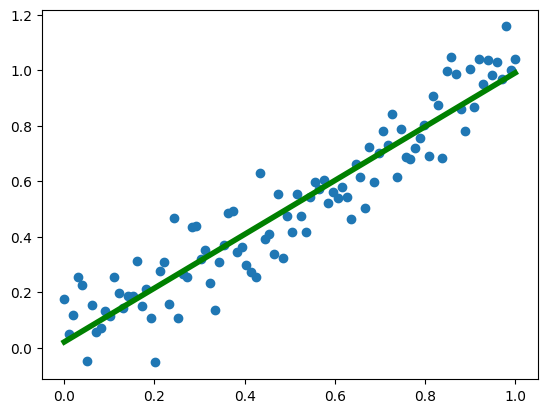

In [ ]:
plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

We’ve just trained our first neural network. Why? A neuron is simply a vector of parameters, and we usually take a dot product of those parameters with the input. On top of that, we apply an **activation function**, which transforms the output. Here there was no activation function — or rather, it was just the identity function.

In practice, we use a proper framework, which in particular:
- makes building networks easier, e.g., by providing ready-made classes for neural layers
- includes implemented cost functions and their derivatives
- automatically differentiates with respect to the right parameters and updates them during training


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

Let’s see what linear regression would look like when written in PyTorch. This is, of course, a very low-level implementation — in a moment we’ll look at how it works in practice.


In [ ]:
learning_rate = 0.1
for i in range(1000):
    loss = mse(y, a * x + b)

    # compute gradients
    loss.backward()

    # update parameters
    a.data -= learning_rate * a.grad
    b.data -= learning_rate * b.grad

    # zero gradients
    a.grad.data.zero_()
    b.grad.data.zero_()

    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  tensor(0.0637, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 100 loss:  tensor(0.0107, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 200 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 300 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 400 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 500 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 600 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 700 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 800 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 900 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Training models in PyTorch is fairly structured and is usually divided into several blocks, which together form the **training loop**, repeated in each epoch:
1. Forward pass – computing the network’s predictions
2. Loss calculation
3. Backpropagation – computing derivatives and zeroing gradients
4. Optimization – updating weights
5. Other – evaluation on the validation set, logging, etc.


In [ ]:
# initialization
learning_rate = 0.1
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
optimizer = torch.optim.SGD([a, b], lr=learning_rate)
best_loss = float("inf")

# training loop in each epoch
for i in range(1000):
    # forward pass
    y_hat = a * x + b

    # loss calculation
    loss = mse(y, y_hat)

    # backpropagation
    loss.backward()

    # optimization
    optimizer.step()
    optimizer.zero_grad()  # zeroes all gradients - very convenient!

    if i % 100 == 0:
        if loss < best_loss:
            best_model = (a.clone(), b.clone())
            best_loss = loss
        print(f"step {i} loss: {loss.item():.4f}")

print("final loss:", loss)

step 0 loss: 0.4534
step 100 loss: 0.0107
step 200 loss: 0.0101
step 300 loss: 0.0101
step 400 loss: 0.0101
step 500 loss: 0.0101
step 600 loss: 0.0101
step 700 loss: 0.0101
step 800 loss: 0.0101
step 900 loss: 0.0101
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


## Zbiór danych

In this notebook, we will use the [Adult Census](https://archive.ics.uci.edu/ml/datasets/adult) dataset. It involves predicting, based on demographic data, whether a person earns more or less than $50,000 per year. This is valuable information, for example, when planning marketing campaigns. As you might guess, the dataset comes from a time when inflation was much lower :)

Below is the code to download and preprocess the dataset. You don’t need to analyze it in detail.


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2025-02-13 17:18:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  6.17MB/s    in 0.6s    

2025-02-13 17:18:10 (6.17 MB/s) - ‘adult.data’ saved [3974305]



In [ ]:
import pandas as pd


columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "wage"
]

"""
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
"""

df = pd.read_csv("adult.data", header=None, names=columns)
df.wage.unique()

array([' <=50K', ' >50K'], dtype=object)

In [ ]:
# attribution: https://www.kaggle.com/code/royshih23/topic7-classification-in-python
df['education'].replace('Preschool', 'dropout',inplace=True)
df['education'].replace('10th', 'dropout',inplace=True)
df['education'].replace('11th', 'dropout',inplace=True)
df['education'].replace('12th', 'dropout',inplace=True)
df['education'].replace('1st-4th', 'dropout',inplace=True)
df['education'].replace('5th-6th', 'dropout',inplace=True)
df['education'].replace('7th-8th', 'dropout',inplace=True)
df['education'].replace('9th', 'dropout',inplace=True)
df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
df['education'].replace('HS-grad', 'HighGrad',inplace=True)
df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
df['education'].replace('Bachelors', 'Bachelors',inplace=True)
df['education'].replace('Masters', 'Masters',inplace=True)
df['education'].replace('Prof-school', 'Masters',inplace=True)
df['education'].replace('Doctorate', 'Doctorate',inplace=True)

df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

<ipython-input-23-34a60972a90f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['education'].replace('Preschool', 'dropout',inplace=True)
<ipython-input-23-34a60972a90f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler


X = df.copy()
y = (X.pop("wage") == ' >50K').astype(int).values

train_valid_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=train_valid_size,
    random_state=0,
    shuffle=True,
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    test_size=train_valid_size,
    random_state=0,
    shuffle=True,
    stratify=y_train
)

continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
continuous_X_train = X_train[continuous_cols]
categorical_X_train = X_train.loc[:, ~X_train.columns.isin(continuous_cols)]

continuous_X_valid = X_valid[continuous_cols]
categorical_X_valid = X_valid.loc[:, ~X_valid.columns.isin(continuous_cols)]

continuous_X_test = X_test[continuous_cols]
categorical_X_test = X_test.loc[:, ~X_test.columns.isin(continuous_cols)]

categorical_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
continuous_scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))

categorical_encoder.fit(categorical_X_train)
continuous_scaler.fit(continuous_X_train)

continuous_X_train = continuous_scaler.transform(continuous_X_train)
continuous_X_valid = continuous_scaler.transform(continuous_X_valid)
continuous_X_test = continuous_scaler.transform(continuous_X_test)

categorical_X_train = categorical_encoder.transform(categorical_X_train)
categorical_X_valid = categorical_encoder.transform(categorical_X_valid)
categorical_X_test = categorical_encoder.transform(categorical_X_test)

X_train = np.concatenate([continuous_X_train, categorical_X_train], axis=1)
X_valid = np.concatenate([continuous_X_valid, categorical_X_valid], axis=1)
X_test = np.concatenate([continuous_X_test, categorical_X_test], axis=1)

X_train.shape, y_train.shape

((20838, 108), (20838,))

In [ ]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float().unsqueeze(-1)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)

Here we are dealing with an imbalanced classification:

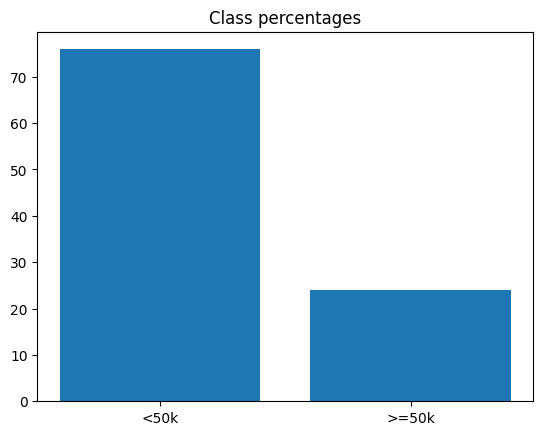

In [ ]:
import matplotlib.pyplot as plt

y_pos_perc = 100 * y_train.sum().item() / len(y_train)
y_neg_perc = 100 - y_pos_perc

plt.title("Class percentages")
plt.bar(["<50k", ">=50k"], [y_neg_perc, y_pos_perc])
plt.show()

Therefore, we will use the appropriate metrics, namely AUROC, precision, and recall.


Implement logistic regression for this dataset using PyTorch.

The network itself consists of 2 elements:
- a linear layer `nn.Linear`, which transforms the input vector into 1 output — a logit
- a sigmoid activation `nn.Sigmoid`, which transforms the logit into the probability of the positive class

Use binary cross-entropy `nn.BCELoss` as the cost function. Use the SGD optimizer with a learning rate of `1e-3`. Train for 3000 epochs. Remember to pass the network parameters (`.parameters()` method) to the optimizer. Add logging of the loss every 100 epochs.


In [ ]:
learning_rate = 1e-3

model = nn.Linear(X_train.shape[1], 1)
activation = nn.Sigmoid()
optimizer = optim.SGD(lr = learning_rate, params=model.parameters())
loss_fn = nn.BCELoss()

best_loss = float('inf')

epochs = 3000

for i in range(epochs):
    #forward pass
    logit = model(X_train)

    #aktywacja - przeksztalcenie logitu na prawdopodobienstwo
    y_pred = activation(logit)

    #kalkulacja loss - uzywamy BCELoss
    loss = loss_fn(y_pred,y_train)

    #backpropagation - obliczenie pochodnych i zerowanie gradientow
    loss.backward()

    #optymalizacja - aktualizacja wag ktore obliczamy z uzyciem SGD
    optimizer.step()
    optimizer.zero_grad()

    if i % 100 == 0:
            if loss < best_loss:
                best_model = (a.clone(), b.clone())
                best_loss = loss
            print(f"step {i} loss: {loss.item():.4f}")




step 0 loss: 0.7015
step 100 loss: 0.6675
step 200 loss: 0.6392
step 300 loss: 0.6154
step 400 loss: 0.5953
step 500 loss: 0.5782
step 600 loss: 0.5634
step 700 loss: 0.5506
step 800 loss: 0.5393
step 900 loss: 0.5294
step 1000 loss: 0.5206
step 1100 loss: 0.5127
step 1200 loss: 0.5055
step 1300 loss: 0.4990
step 1400 loss: 0.4931
step 1500 loss: 0.4876
step 1600 loss: 0.4826
step 1700 loss: 0.4779
step 1800 loss: 0.4736
step 1900 loss: 0.4695
step 2000 loss: 0.4657
step 2100 loss: 0.4621
step 2200 loss: 0.4588
step 2300 loss: 0.4556
step 2400 loss: 0.4526
step 2500 loss: 0.4497
step 2600 loss: 0.4470
step 2700 loss: 0.4444
step 2800 loss: 0.4419
step 2900 loss: 0.4395


In [ ]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, roc_auc_score


model.eval()
with torch.no_grad():
    y_score = activation(model(X_test))

auroc = roc_auc_score(y_test, y_score)
print(f"AUROC: {100 * auroc:.2f}%")

AUROC: 85.20%


This is a pretty good result, and it can get even better. Let’s also check other metrics: precision, recall, and F1-score. Additionally, we will plot the precision-recall curve, showing how these metrics change depending on the probability threshold above which we classify a sample as positive. This curve should be plotted on the validation set, because later we want to use this information to select the threshold, and we don’t want any test data leakage.

Below, a function `get_optimal_threshold()` is also implemented, which checks for which threshold we get the maximum F1-score and returns the index and value of the optimal threshold.

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay


def get_optimal_threshold(
    precisions: np.array,
    recalls: np.array,
    thresholds: np.array
) -> Tuple[int, float]:

    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_idx, optimal_threshold


def plot_precision_recall_curve(y_true, y_pred_score) -> None:
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_score)
    optimal_idx, optimal_threshold = get_optimal_threshold(precisions, recalls, thresholds)

    disp = PrecisionRecallDisplay(precisions, recalls)
    disp.plot()
    plt.title(f"Precision-recall curve (opt. thresh.: {optimal_threshold:.4f})")
    plt.axvline(recalls[optimal_idx], color="green", linestyle="-.")
    plt.axhline(precisions[optimal_idx], color="green", linestyle="-.")
    plt.show()


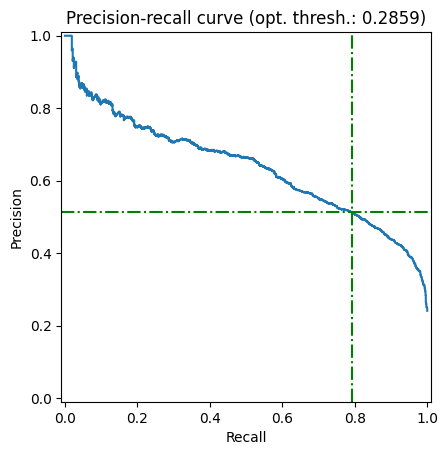

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_valid_score = activation(model(X_valid))

plot_precision_recall_curve(y_valid, y_pred_valid_score)

As you can see, although the AUROC is high, for the optimal F1-score the recall is not very high, and precision is already quite low. It may be possible to improve the result by using a higher-capacity model — a full, deep neural network.


## Multilayer Perceptor Model

#### Task 4 (0.5 points)

Complete the implementation of a 3-layer MLP. Use the following sizes:
* first layer: input_size x 256
* second layer: 256 x 128
* third layer: 128 x 1

Use the ReLU activation function.

Useful classes:
- `nn.Sequential`
- `nn.Linear`
- `nn.ReLU`


In [ ]:
from torch import sigmoid
import torch.nn.functional as R


class MLP(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,1)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [ ]:
learning_rate = 1e-3
model = MLP(input_size=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss()
num_epochs = 2000
evaluation_steps = 200

for i in range(num_epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if i % evaluation_steps == 0:
        print(f"Epoch {i} train loss: {loss.item():.4f}")

print(f"final loss: {loss.item():.4f}")

Epoch 0 train loss: 0.6635
Epoch 200 train loss: 0.6446
Epoch 400 train loss: 0.6282
Epoch 600 train loss: 0.6136
Epoch 800 train loss: 0.6006
Epoch 1000 train loss: 0.5889
Epoch 1200 train loss: 0.5783
Epoch 1400 train loss: 0.5688
Epoch 1600 train loss: 0.5601
Epoch 1800 train loss: 0.5522
final loss: 0.5450


AUROC: 81.77%


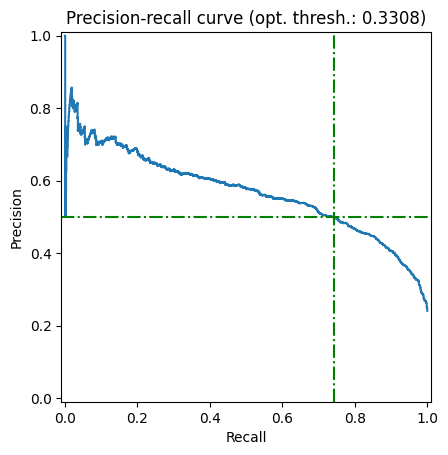

In [ ]:
model.eval()
with torch.no_grad():
    # positive class probabilities
    y_pred_valid_score = model.predict_proba(X_valid)
    y_pred_test_score = model.predict_proba(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)
print(f"AUROC: {100 * auroc:.2f}%")

plot_precision_recall_curve(y_valid, y_pred_valid_score)

The AUROC is similar, but precision and recall have dropped — we even perform worse than linear regression! Since we added more layers, maybe the model’s capacity is now too large and needs regularization?

Neural networks easily overfit because they are very flexible and high-capacity models. That’s why there are many types of regularization, often used together. Interestingly, it has been experimentally shown that very large networks with strong regularization perform better than smaller networks of appropriate size with weaker regularization.

The first type of regularization is the already known **L2 regularization**, which penalizes excessively large weights. In the context of neural networks, it is sometimes called *weight decay*. In PyTorch, it is added as an argument to the optimizer.

A neural-network-specific regularization is **dropout**. It involves randomly disabling a given percentage of neurons during training. Despite its simplicity, it has proven extremely effective, especially in training very deep networks. Importantly, this mechanism is used only during training — during prediction, dropout is turned off and the network makes normal predictions. This approach can be seen as a form of ensemble learning, similar to random forests — by disabling random parts of the network, each iteration trains a slightly different network, which corresponds to averaging predictions of different models. Dropout is typically applied quite heavily, around 25-50%. In PyTorch, it is implemented with `nn.Dropout`, usually applied after the activation function.

The last, and perhaps most important, type of regularization is **early stopping**. Each step adapts the network more strongly to the training set, so training for too long will lead to overfitting. Early stopping uses a separate validation set (single, holdout method), checking the performance every few epochs. If no improvement over the best score so far is observed for a certain number of epochs, training is stopped. The period we wait for improvement is called *patience*. The smaller it is, the stronger this regularization is, but caution is needed, as stopping too early can hinder training. Some implementations include a *grace period*, which guarantees a minimum number of epochs regardless of the chosen patience.

Additionally, the risk of overfitting can be reduced by using a smaller learning rate.


Implement the function `evaluate_model()`, which calculates metrics on the test set:
- loss value
- AUROC
- optimal threshold
- F1-score at the optimal threshold
- precision and recall at the optimal threshold

If a value for the `threshold` argument is provided, use it to convert probabilities into hard predictions. Otherwise, use the `get_optimal_threshold` function to calculate the optimal threshold.


In [ ]:
from typing import Optional

from sklearn.metrics import precision_score, recall_score, f1_score
from torch import sigmoid


def evaluate_model(
    model: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor,
    loss_fn: nn.Module,
    threshold: Optional[float]= None
) -> Dict[str, float]:

    model.eval()

    with torch.no_grad():
        #forward pass
        logits = model(X)
        y_pred = sigmoid(logits)

        #kalkulacja loss
        loss = loss_fn(y_pred, y)

        auroc = roc_auc_score(y, y_pred)

        precisions, recalls, thresholds = precision_recall_curve(y, y_pred)

        if threshold is not None:
            optimal_threshold = threshold
        else:
            optimal_idx, optimal_threshold = get_optimal_threshold(precisions, recalls, thresholds)


        y_pred_hard = (y_pred >= optimal_threshold).float()


        f1 = f1_score(y, y_pred_hard)
        precision = precision_score(y, y_pred_hard)
        recall = recall_score(y, y_pred_hard)

    return {
        "loss": loss,
        "AUROC": auroc,
        "optimal_threshold": threshold,
        "F1_score": f1,
        "precision": precision,
        "recall": recall
    }




Implement a 3-layer MLP with dropout (50%). The hidden layer sizes should be 256 and 128.


In [ ]:
class RegularizedMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1)

        )

    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


Earlier, we described the basic optimizer in neural networks — gradient descent. However, it requires using the entire dataset to compute the gradient, which is often infeasible due to dataset size. That’s why **stochastic gradient descent (SGD)** was invented, where we use one example at a time, compute the gradient only for it, and update the parameters. This is, of course, a rather rough approximation of the gradient, but it allows for many small steps to be taken quickly. A practical compromise is **minibatch gradient descent**, using batches of, for example, 32, 64, or 128 examples.

A rarely mentioned but important fact is that the stochasticity of the optimization method itself also acts as a [regularization method](https://arxiv.org/abs/2101.12176), so `batch_size` is also a hyperparameter.

Currently, the most popular variant of SGD is [Adam](https://arxiv.org/abs/1412.6980), as it trains networks quickly and gives very good results even with not perfectly tuned hyperparameters.

For now, however, we will use minibatch SGD.


In [ ]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data, y):
        super().__init__()

        self.data = data
        self.y = y

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]


Implement a training-validation loop for a neural network. Use the provided hyperparameter values for training (learning rate, dropout probability, L2 regularization, batch size, maximum number of epochs). Use the SGD optimizer.

Additionally, implement early stopping regularization. Check the performance on the validation set every epoch. Use the provided patience value, and use the cost function value as the metric. The previously implemented `evaluate_model()` function may be useful here.

Remember to store the best validation performance so far and the corresponding best model. Also, save the optimal classification threshold for the best model.


In [ ]:
from copy import deepcopy

from torch.utils.data import DataLoader


learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

In [ ]:
model = RegularizedMLP(
    input_size=X_train.shape[1],
    dropout_p=dropout_p
)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=l2_reg
)
loss_fn = torch.nn.BCEWithLogitsLoss()

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        #forward pass
        y_pred = model(X_batch)

        #loss calc
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        #optymalizacja
        optimizer.step()
        optimizer.zero_grad()


        if i % evaluation_steps == 0:
            print(f"Epoch {i} train loss: {loss.item():.4f}")


    # model evaluation, early stopping
    valid_metrics = evaluate_model(model ,X_valid, y_valid, loss_fn)

    valid_loss = round(valid_metrics['loss'].item(),4)

    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_loss}")

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model = deepcopy(model)
        best_threshold = valid_metrics['optimal_threshold']
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1

    if steps_without_improvement >= early_stopping_patience:
        print(f"Early stoping activated after {epoch_num} epochs")
        break


Epoch 0 train loss: 0.6754, eval loss 0.8464
Epoch 1 train loss: 0.6572, eval loss 0.8401
Epoch 2 train loss: 0.6468, eval loss 0.8344
Epoch 3 train loss: 0.6312, eval loss 0.829
Epoch 4 train loss: 0.6216, eval loss 0.824
Epoch 5 train loss: 0.6101, eval loss 0.8193
Epoch 6 train loss: 0.5965, eval loss 0.8148
Epoch 7 train loss: 0.5892, eval loss 0.8106
Epoch 8 train loss: 0.5790, eval loss 0.8066
Epoch 9 train loss: 0.5696, eval loss 0.8028
Epoch 10 train loss: 0.5648, eval loss 0.7991
Epoch 11 train loss: 0.5721, eval loss 0.7957
Epoch 12 train loss: 0.5512, eval loss 0.7924
Epoch 13 train loss: 0.5471, eval loss 0.7893
Epoch 14 train loss: 0.5493, eval loss 0.7863
Epoch 15 train loss: 0.5494, eval loss 0.7835
Epoch 16 train loss: 0.5358, eval loss 0.7808
Epoch 17 train loss: 0.5334, eval loss 0.7782
Epoch 18 train loss: 0.5350, eval loss 0.7758
Epoch 19 train loss: 0.5221, eval loss 0.7735
Epoch 20 train loss: 0.5214, eval loss 0.7713
Epoch 21 train loss: 0.5249, eval loss 0.7692


In [ ]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1_score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 89.57%
F1: 67.75%
Precision: 63.34%
Recall: 72.83%


The results are already much better.

Finally, we will add three commonly used techniques to our model, which are very simple but often improve model performance.

The first is **normalization layers**. They were originally introduced based on the idea that transformations applied by the network change the probability distribution between layers, i.e., the so-called *internal covariate shift*. Later, it turned out that applying such normalization smooths the cost function surface, making optimization easier and faster. The most commonly used normalization is **batch normalization (batch norm)**.

The second improvement is adding **class weights**. We are dealing with an imbalanced classification problem, so the minority class, which is more important to us, should get a higher weight. This is implemented very simply — just multiply the cost function value for a given example by the weight of its true class. Practically any classifier using a weighted loss can work this way, not just neural networks.

The last improvement is replacing SGD with the Adam optimizer, specifically `AdamW`. This is an example of an **adaptive optimizer**, which can adjust the learning rate individually for each parameter during training. It uses the gradients for this — in short, the larger the variance of a gradient, the smaller the step we take in that direction.


Implement the `NormalizingMLP` model, with the same structure as `RegularizedMLP`, but additionally with `BatchNorm1d` layers between the `Linear` and `ReLU` layers.

Use the `compute_class_weight()` function to calculate weights for each class. Use the `"balanced"` option. Pass the positive class weight to the loss function (remember to convert it to a tensor).

Replace the optimizer with `AdamW`.

In [ ]:
class NormalizingMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1)

        )


    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# define all the hyperparameters

learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300
early_stopping_patience = 4

model = NormalizingMLP(
    input_size=X_train.shape[1],
    dropout_p=dropout_p
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=l2_reg
)

y_train_arr = y_train.numpy().ravel()

classes = np.unique(y_train_arr)

class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = y_train_arr
)

positive_class_weight = class_weights[1]

loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([positive_class_weight], dtype=torch.float32))


In [ ]:
# training loop

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        #forward pass
        # logits = model(X_batch)
        # y_batch_pred = sigmoid(logits)
        y_pred = model(X_batch)

        #loss calc
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        #optymalizacja
        optimizer.step()
        optimizer.zero_grad()


        if i % evaluation_steps == 0:
            print(f"Epoch {i} train loss: {loss.item():.4f}")


    # model evaluation, early stopping
    valid_metrics = evaluate_model(model ,X_valid, y_valid, loss_fn)

    valid_loss = round(valid_metrics['loss'].item(),4)

    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_loss}")

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model = deepcopy(model)
        best_threshold = valid_metrics['optimal_threshold']
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1

    if steps_without_improvement >= early_stopping_patience:
        print(f"Early stoping activated after {epoch_num} epochs")
        break


Epoch 0 train loss: 0.5327, eval loss 0.8211
Epoch 1 train loss: 0.6107, eval loss 0.8173
Epoch 2 train loss: 0.6111, eval loss 0.8163
Epoch 3 train loss: 0.5087, eval loss 0.8137
Epoch 4 train loss: 0.5752, eval loss 0.8138
Epoch 5 train loss: 0.5736, eval loss 0.8115
Epoch 6 train loss: 0.5891, eval loss 0.8119
Epoch 7 train loss: 0.5216, eval loss 0.8117
Epoch 8 train loss: 0.5516, eval loss 0.8114
Epoch 9 train loss: 0.5601, eval loss 0.8119
Epoch 10 train loss: 0.5358, eval loss 0.8113
Epoch 11 train loss: 0.5812, eval loss 0.8103
Epoch 12 train loss: 0.5176, eval loss 0.8114
Epoch 13 train loss: 0.5846, eval loss 0.8103
Epoch 14 train loss: 0.4957, eval loss 0.81
Epoch 15 train loss: 0.4862, eval loss 0.8103
Epoch 16 train loss: 0.5284, eval loss 0.8095
Epoch 17 train loss: 0.4812, eval loss 0.8098
Epoch 18 train loss: 0.5011, eval loss 0.8095
Epoch 19 train loss: 0.5445, eval loss 0.8098
Epoch 20 train loss: 0.4899, eval loss 0.8102
Early stoping activated after 20 epochs


In [ ]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1_score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 90.75%
F1: 69.74%
Precision: 61.53%
Recall: 80.48%
